<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-25_23_30_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [16]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [19]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [20]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size, pin_memory=True)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size, pin_memory=True)

In [21]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [22]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [23]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [24]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    idx = 0
    bound = ((60000//batch_size)*0.6)//1
    record_label = np.array([], dtype=int)
    print('Bound is', bound, 'times')
    # Calculate Fisher Matrix
    for data in train_loader:
        if idx == bound: break
        else: idx += 1

        img, label = data
        img, label = img.to(device), label.to(device).long()

        # flag
        record_label = np.append(record_label, label.cpu().numpy())
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)
    print('Number of Digits after Sampling', np.bincount(record_label)) # flag
    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= idx #len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [25]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [26]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.8148, Loss:  0.0033
Epoch	2	Acc:  0.8910, Loss:  0.0017
Epoch	3	Acc:  0.9037, Loss:  0.0014
Epoch	4	Acc:  0.9106, Loss:  0.0013
Epoch	5	Acc:  0.9146, Loss:  0.0012
Epoch	6	Acc:  0.9169, Loss:  0.0012
Epoch	7	Acc:  0.9191, Loss:  0.0011
Epoch	8	Acc:  0.9212, Loss:  0.0011
Epoch	9	Acc:  0.9230, Loss:  0.0011
Epoch	10	Acc:  0.9234, Loss:  0.0011
Bound is 140.0 times
Number of Digits after Sampling [3533 3932 3589 3663 3451 3303 3527 3782 3487 3573]
Task 0 Acc:  0.9236, Loss:  0.0011
Task 1 Acc:  0.1354, Loss:  0.0262

Task 1 Start!
Epoch	1	Acc:  0.3954, Loss:  0.0116
Epoch	2	Acc:  0.7059, Loss:  0.0055
Epoch	3	Acc:  0.7686, Loss:  0.0045
Epoch	4	Acc:  0.7952, Loss:  0.0041
Epoch	5	Acc:  0.8083, Loss:  0.0039
Epoch	6	Acc:  0.8169, Loss:  0.0037
Epoch	7	Acc:  0.8225, Loss:  0.0036
Epoch	8	Acc:  0.8256, Loss:  0.0035
Epoch	9	Acc:  0.8278, Loss:  0.0035
Epoch	10	Acc:  0.8297, Loss:  0.0034
Bound is 140.0 times
Number of Digits after Sampling [3532 4048 3552 3632 

 - Task 0

Accuracy 0.6046
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.75      0.66      0.70       980
     1 - one       0.99      0.63      0.77      1135
     2 - two       0.50      0.29      0.37      1032
   3 - three       0.55      0.65      0.60      1010
    4 - four       0.40      0.84      0.54       982
    5 - five       0.53      0.21      0.30       892
     6 - six       0.73      0.85      0.78       958
   7 - seven       0.82      0.57      0.68      1028
   8 - eight       0.45      0.51      0.48       974
    9 - nine       0.64      0.81      0.71      1009

    accuracy                           0.60     10000
   macro avg       0.64      0.60      0.59     10000
weighted avg       0.64      0.60      0.60     10000



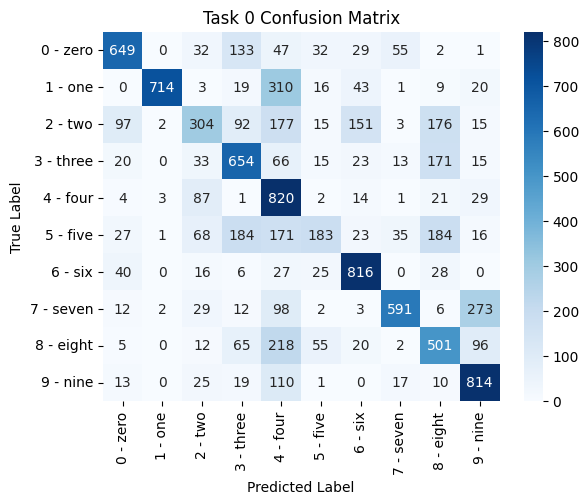

In [27]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.8382
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.93      0.96      0.94       980
     1 - one       0.93      0.95      0.94      1135
     2 - two       0.90      0.81      0.85      1032
   3 - three       0.82      0.83      0.83      1010
    4 - four       0.75      0.76      0.75       982
    5 - five       0.73      0.66      0.70       892
     6 - six       0.88      0.86      0.87       958
   7 - seven       0.88      0.88      0.88      1028
   8 - eight       0.76      0.82      0.79       974
    9 - nine       0.77      0.81      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



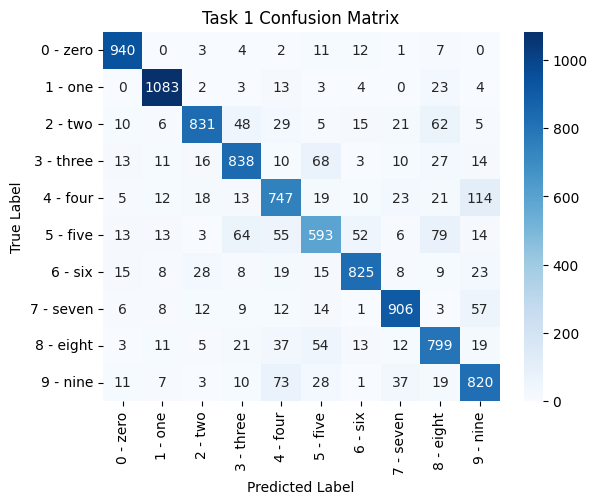

In [28]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.00462 and it's parameter diff is 0.01064
Min Parameter diff is 0.59461 and it's fisher is 0.00001
fisher > parameter diff: 24
fisher <= parameter diff: 760


<Figure size 640x480 with 0 Axes>

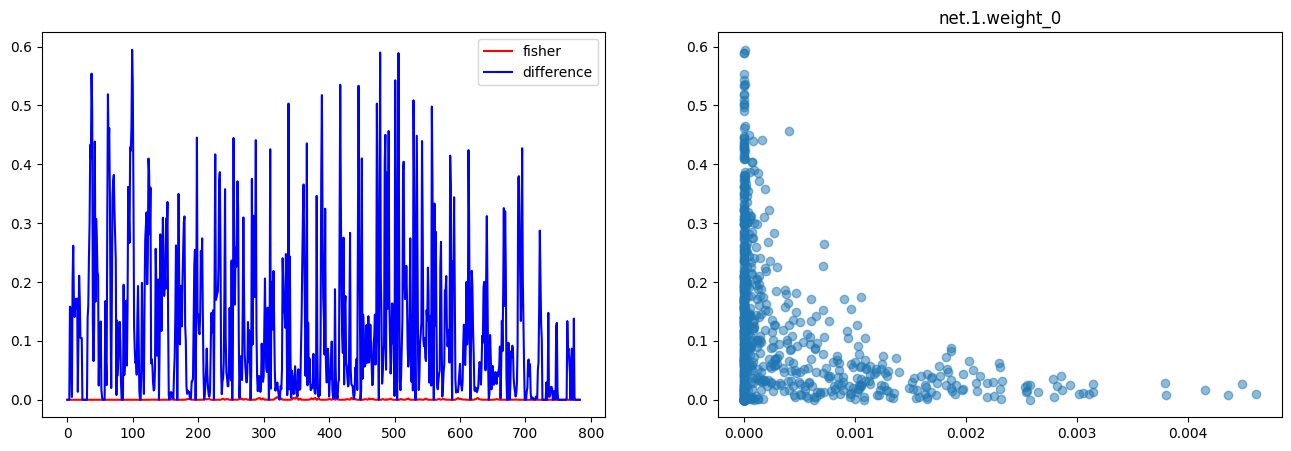

Max fisher is 0.01135 and it's parameter diff is 0.02434
Min Parameter diff is 0.90116 and it's fisher is 0.00000
fisher > parameter diff: 28
fisher <= parameter diff: 756


<Figure size 640x480 with 0 Axes>

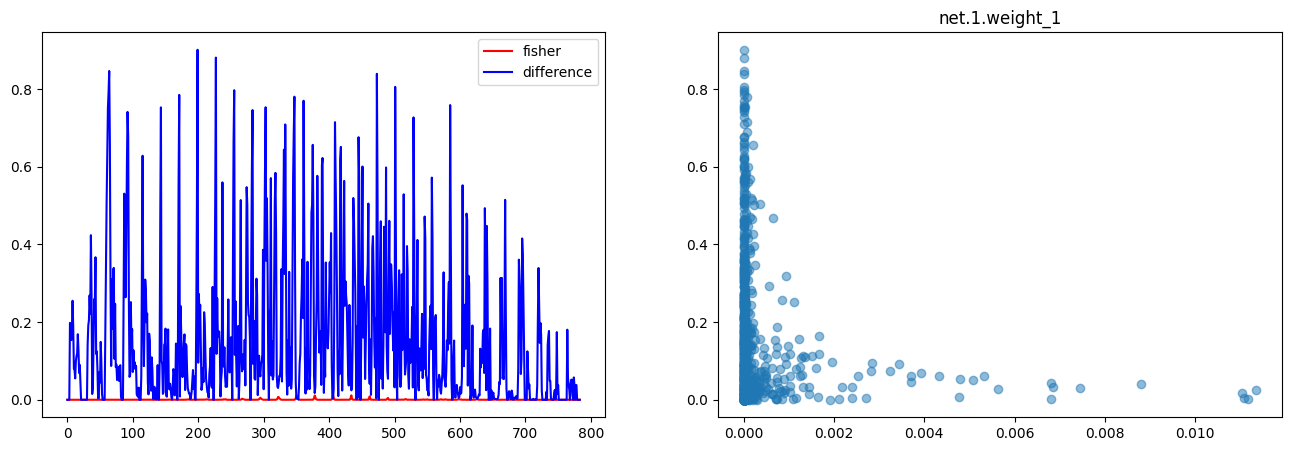

Max fisher is 0.00522 and it's parameter diff is 0.00376
Min Parameter diff is 0.89500 and it's fisher is 0.00006
fisher > parameter diff: 23
fisher <= parameter diff: 761


<Figure size 640x480 with 0 Axes>

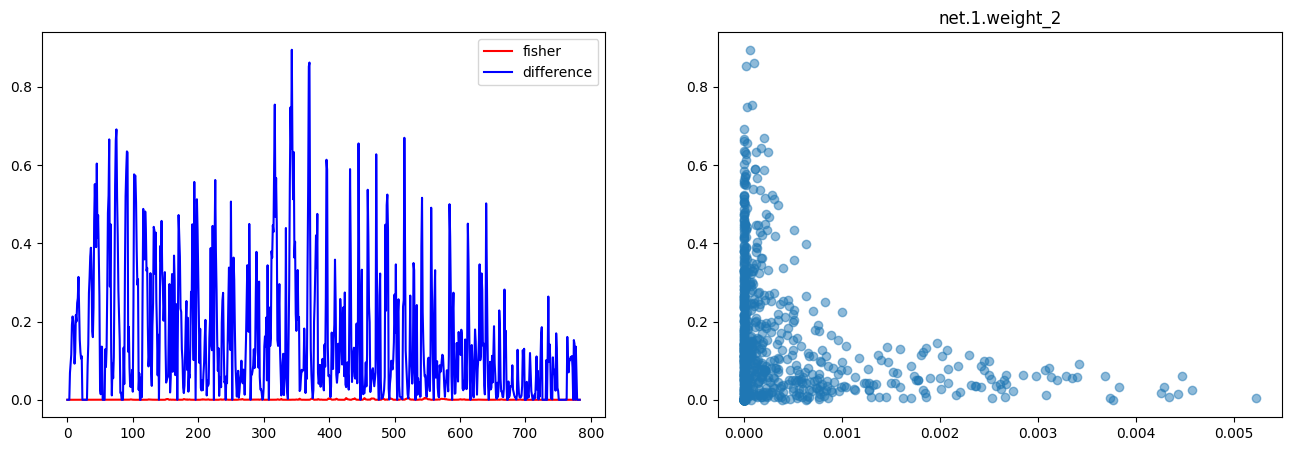

Max fisher is 0.00990 and it's parameter diff is 0.00836
Min Parameter diff is 0.84606 and it's fisher is 0.00001
fisher > parameter diff: 32
fisher <= parameter diff: 752


<Figure size 640x480 with 0 Axes>

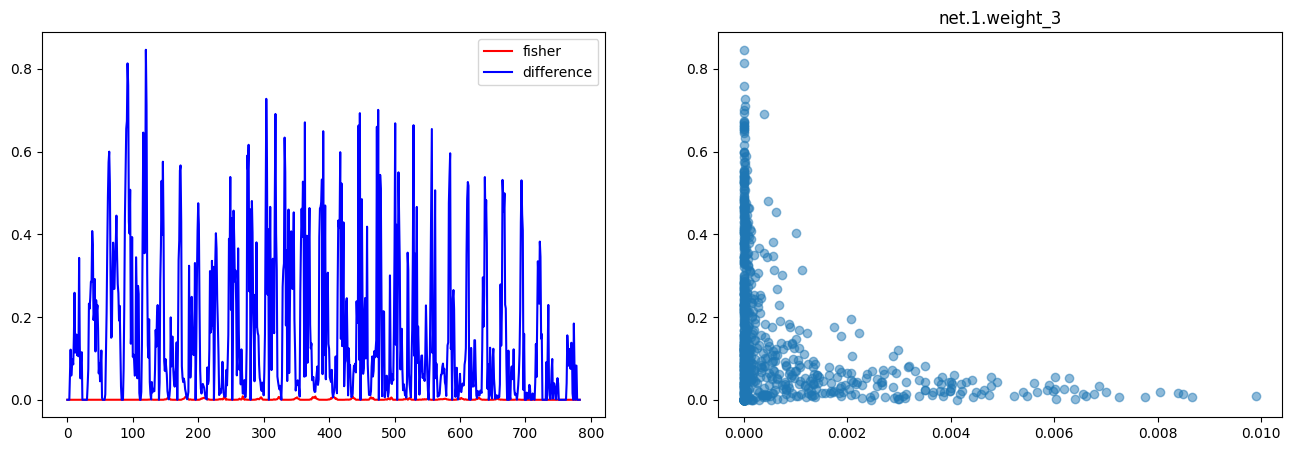

Max fisher is 0.03872 and it's parameter diff is 0.00220
Min Parameter diff is 1.03937 and it's fisher is 0.00000
fisher > parameter diff: 62
fisher <= parameter diff: 722


<Figure size 640x480 with 0 Axes>

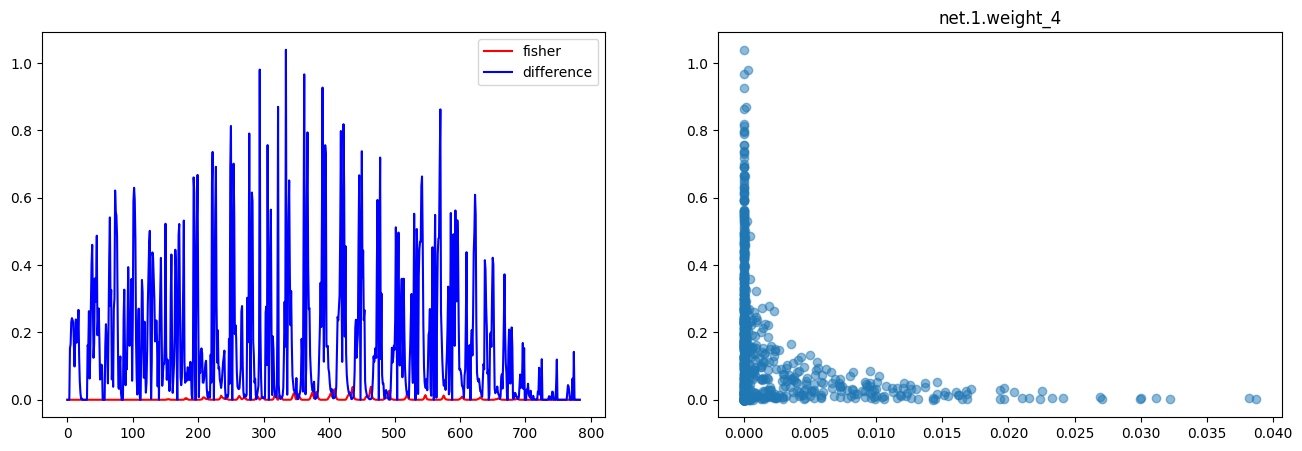

Max fisher is 0.02441 and it's parameter diff is 0.01442
Min Parameter diff is 1.00150 and it's fisher is 0.00000
fisher > parameter diff: 74
fisher <= parameter diff: 710


<Figure size 640x480 with 0 Axes>

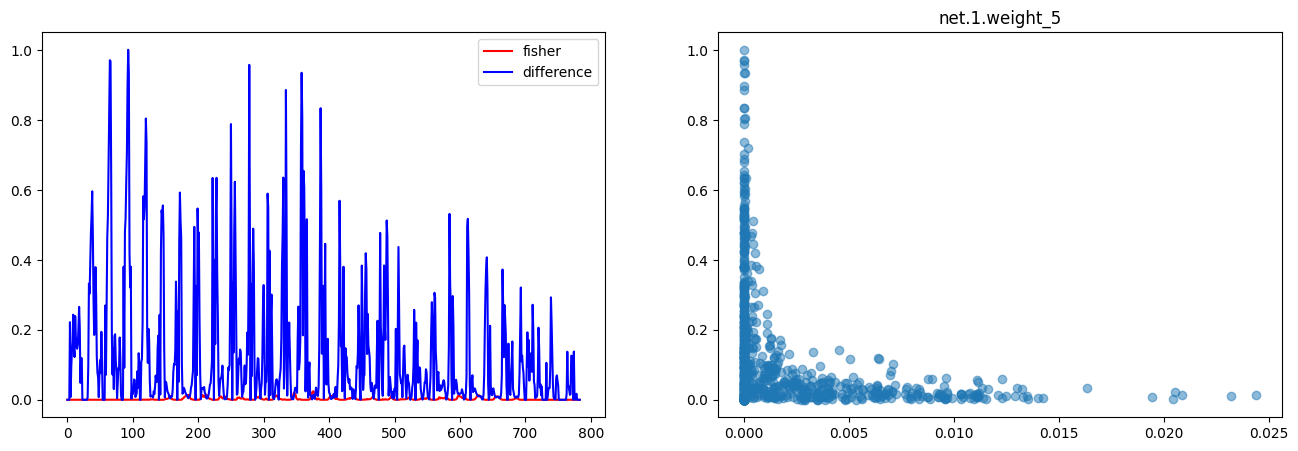

Max fisher is 0.01166 and it's parameter diff is 0.01578
Min Parameter diff is 1.01077 and it's fisher is 0.00000
fisher > parameter diff: 54
fisher <= parameter diff: 730


<Figure size 640x480 with 0 Axes>

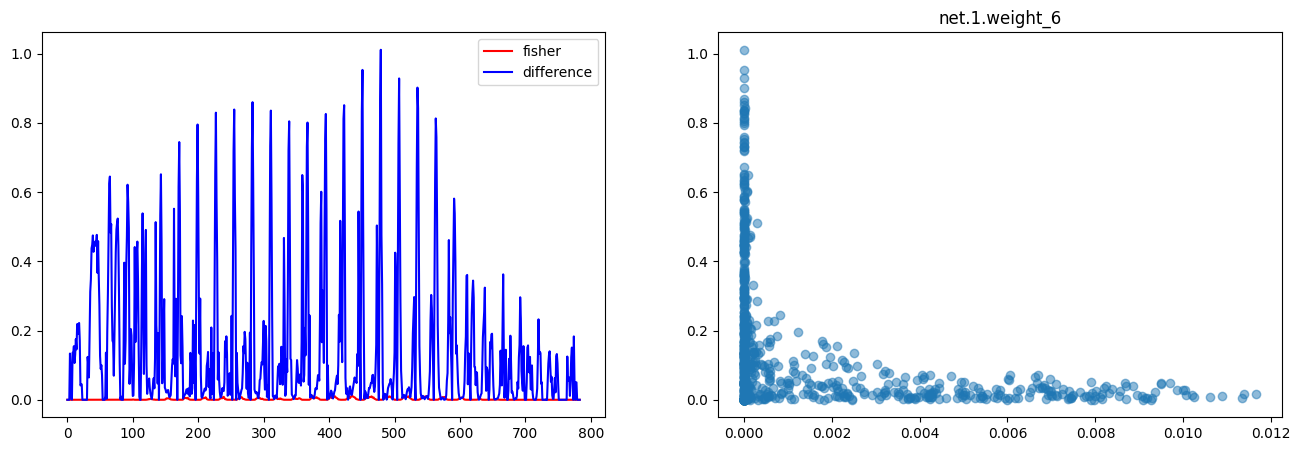

Max fisher is 0.00913 and it's parameter diff is 0.01584
Min Parameter diff is 0.75203 and it's fisher is 0.00011
fisher > parameter diff: 36
fisher <= parameter diff: 748


<Figure size 640x480 with 0 Axes>

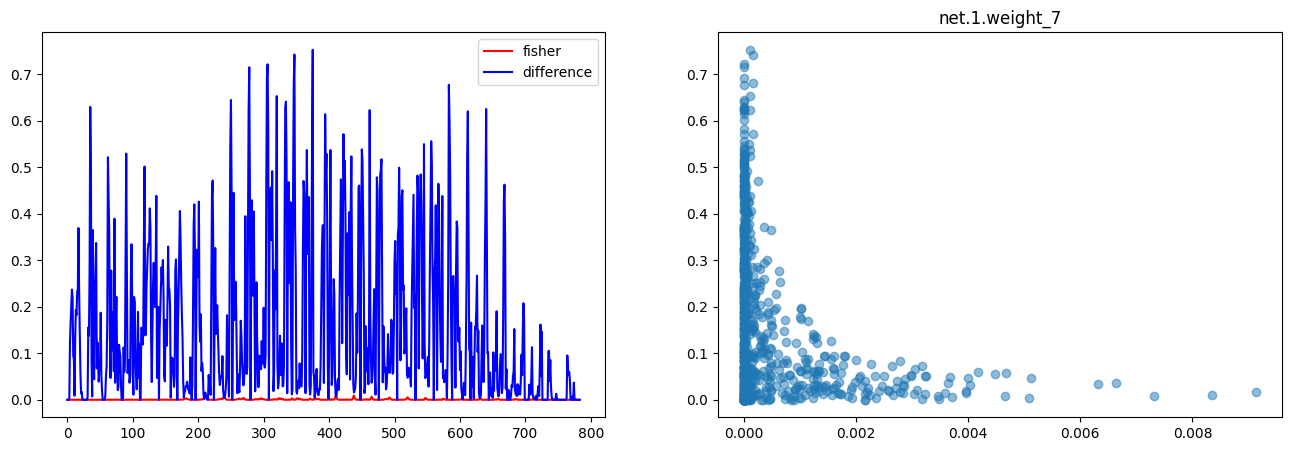

Max fisher is 0.00404 and it's parameter diff is 0.01024
Min Parameter diff is 0.88295 and it's fisher is 0.00000
fisher > parameter diff: 22
fisher <= parameter diff: 762


<Figure size 640x480 with 0 Axes>

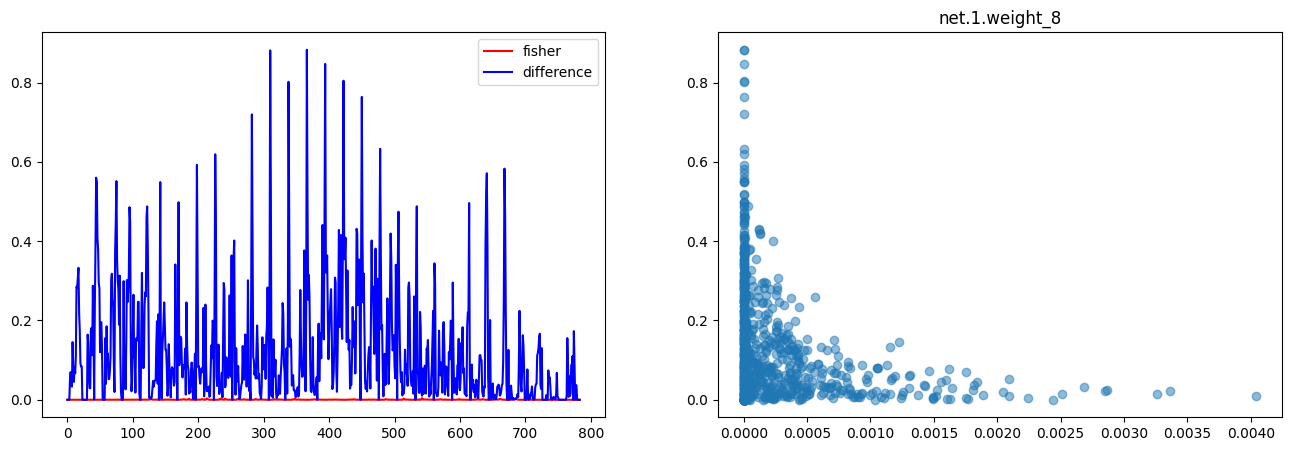

Max fisher is 0.02786 and it's parameter diff is 0.00007
Min Parameter diff is 1.06615 and it's fisher is 0.00000
fisher > parameter diff: 117
fisher <= parameter diff: 667


<Figure size 640x480 with 0 Axes>

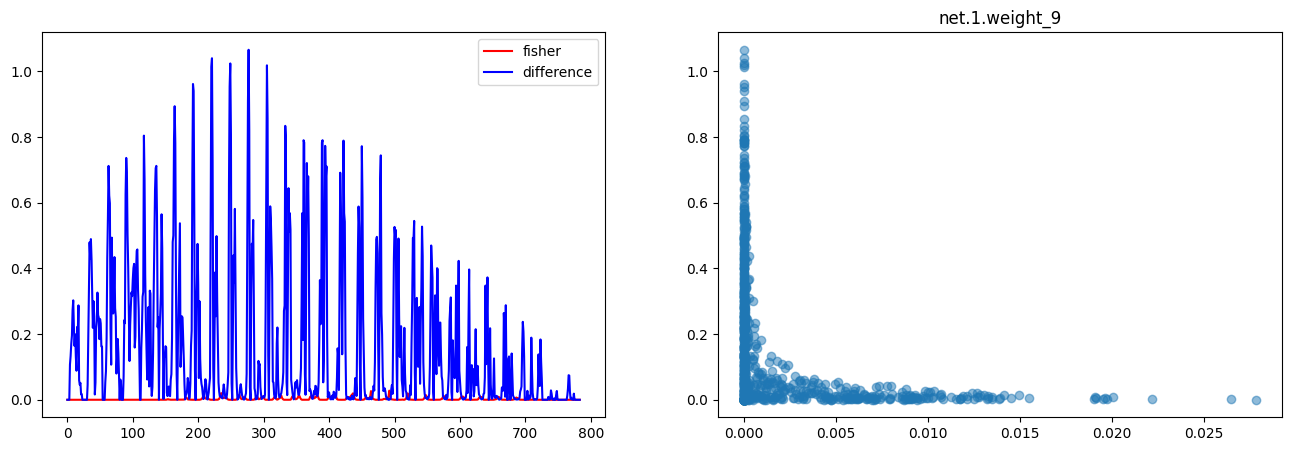


net.1.bias
torch.Size([10])
Max fisher is 0.14100 and it's parameter diff is 0.00065
Min Parameter diff is 0.01141 and it's fisher is 0.01071
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

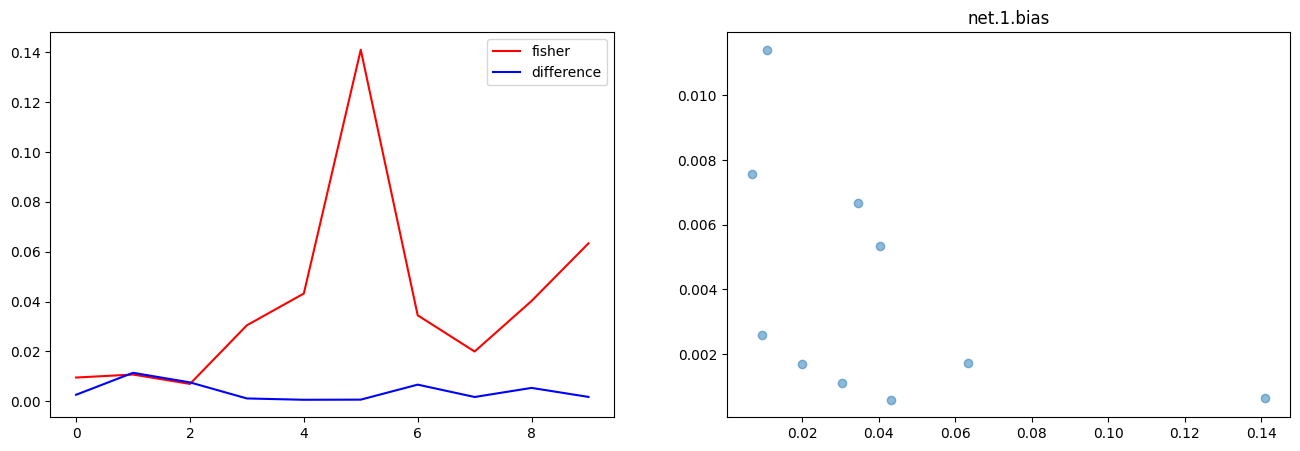

In [29]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [30]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_23_30_22
